# Implementaremos o Naive Bayes para ter uma base de acurácia

Importando as bibliotecas necessárias

In [11]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


Pegando a base de dados de treino

In [12]:
train = pd.read_csv("/home/thiago/datamining/obesity_risk/data/train.csv")

In [13]:
train.shape

(20758, 18)

Pegando a base de dados de teste

In [14]:
test = pd.read_csv("/home/thiago/datamining/obesity_risk/data/test.csv")

In [15]:
train.head(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [16]:
test.head(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


A coluna id é desnecessária

In [17]:
train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

Testando se tem algum dado vazio

In [18]:
NAs = pd.concat([train.isnull().sum()], axis=1, keys=["Train"])
NAs[NAs.sum(axis=1)>0]

,Train


Nenhum dado vazio

Vendo os tipos de dado de cada coluna

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

Todos com tipo 'object' tem que ser convertidos

Vendo a quantidade de dados unicos que cada objeto tem

In [20]:
train.nunique()

Gender                               2
Age                               1703
Height                            1833
Weight                            1979
family_history_with_overweight       2
FAVC                                 2
FCVC                               934
NCP                                689
CAEC                                 4
SMOKE                                2
CH2O                              1506
SCC                                  2
FAF                               1360
TUE                               1297
CALC                                 3
MTRANS                               5
NObeyesdad                           7
dtype: int64

In [21]:
test.nunique()

Gender                               2
Age                               1539
Height                            1739
Weight                            1798
family_history_with_overweight       2
FAVC                                 2
FCVC                               828
NCP                                649
CAEC                                 4
SMOKE                                2
CH2O                              1366
SCC                                  2
FAF                               1260
TUE                               1172
CALC                                 4
MTRANS                               5
dtype: int64

Para objetos com mais de 2 dados unicos faremos um dicionario

In [22]:
categorical_columns = train.select_dtypes(include= ['object'])
categorical_columns.columns

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

Esses tem que ser convertidos

In [23]:
train['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

dicionario com 7 entradas

In [24]:
target = {'Insufficient_Weight' : '0',
          'Normal_Weight' : '1',
          'Overweight_Level_I' : '2',
          'Overweight_Level_II' : '3',
          'Obesity_Type_I' : '4',
          'Obesity_Type_II' : '5',
          'Obesity_Type_III' : '6',
        }

In [25]:
train['NObeyesdad'] = train['NObeyesdad'].replace(target).astype('int64')
train['NObeyesdad'].unique()

array([3, 1, 0, 6, 5, 2, 4])

repetir o procedimento acima com as outras colunas

In [26]:
train['MTRANS'].unique()

array(['Public_Transportation', 'Automobile', 'Walking', 'Motorbike',
       'Bike'], dtype=object)

In [27]:
target = {'Walking' : '0',
          'Bike' : '1',
          'Motorbike' : '2',
          'Public_Transportation' : '3',
          'Automobile' : '4',
          }

In [28]:
train['MTRANS'] = train['MTRANS'].replace(target).astype('int64')
train['MTRANS'].unique()

array([3, 4, 0, 2, 1])

In [29]:
test['MTRANS'] = test['MTRANS'].replace(target).astype('int64')

In [30]:
train['CAEC'].unique()

array(['Sometimes', 'Frequently', 'no', 'Always'], dtype=object)

In [31]:
train['CALC'].unique()

array(['Sometimes', 'no', 'Frequently'], dtype=object)

In [32]:
target = {'no' : '0',
          'Sometimes' : '1',
          'Frequently' : '2',
          'Always' : '3',
          }

In [33]:
train['CAEC'] = train['CAEC'].replace(target).astype('int64')
train['CAEC'].unique()

array([1, 2, 0, 3])

In [34]:
test['CAEC'] = test['CAEC'].replace(target).astype('int64')

In [35]:
target = {'no' : '0',
          'Sometimes' : '1',
          'Frequently' : '2',
          'Always' : '3',
          }

In [36]:
train['CALC'] = train['CALC'].replace(target).astype('int64')
train['CALC'].unique()

array([1, 0, 2])

In [37]:
test['CALC'] = test['CALC'].replace(target).astype('int64')
test['CALC'].unique()

array([1, 0, 2, 3])

In [38]:
train.nunique()

Gender                               2
Age                               1703
Height                            1833
Weight                            1979
family_history_with_overweight       2
FAVC                                 2
FCVC                               934
NCP                                689
CAEC                                 4
SMOKE                                2
CH2O                              1506
SCC                                  2
FAF                               1360
TUE                               1297
CALC                                 3
MTRANS                               5
NObeyesdad                           7
dtype: int64

In [39]:
test.nunique()

Gender                               2
Age                               1539
Height                            1739
Weight                            1798
family_history_with_overweight       2
FAVC                                 2
FCVC                               828
NCP                                649
CAEC                                 4
SMOKE                                2
CH2O                              1366
SCC                                  2
FAF                               1260
TUE                               1172
CALC                                 4
MTRANS                               5
dtype: int64

Restam apenas os com 2 opções, entao usaremos o getdummies

In [40]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [41]:
train.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'Gender_Female', 'Gender_Male',
       'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes', 'SMOKE_no',
       'SMOKE_yes', 'SCC_no', 'SCC_yes'],
      dtype='object')

So precisamos de 1 coluna para cada, logo vamos remover algumas

In [42]:
test.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,...,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes
0,26.899886,1.848294,120.644178,2.938616,3.000000,1,2.825629,0.855400,0.000000,1,...,False,True,False,True,False,True,True,False,True,False
1,21.000000,1.600000,66.000000,2.000000,1.000000,1,3.000000,1.000000,0.000000,1,...,True,False,False,True,False,True,True,False,True,False
2,26.000000,1.643355,111.600553,3.000000,3.000000,1,2.621877,0.000000,0.250502,1,...,True,False,False,True,False,True,True,False,True,False
3,20.979254,1.553127,103.669116,2.000000,2.977909,1,2.786417,0.094851,0.000000,1,...,False,True,False,True,False,True,True,False,True,False
4,26.000000,1.627396,104.835346,3.000000,3.000000,1,2.653531,0.000000,0.741069,1,...,True,False,False,True,False,True,True,False,True,False


In [43]:
train = train.drop(columns=['Gender_Female','family_history_with_overweight_no','FAVC_no','SMOKE_no','SCC_no',])
test = test.drop(columns=['Gender_Female','family_history_with_overweight_no','FAVC_no','SMOKE_no','SCC_no',])

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 20758 non-null  float64
 1   Height                              20758 non-null  float64
 2   Weight                              20758 non-null  float64
 3   FCVC                                20758 non-null  float64
 4   NCP                                 20758 non-null  float64
 5   CAEC                                20758 non-null  int64  
 6   CH2O                                20758 non-null  float64
 7   FAF                                 20758 non-null  float64
 8   TUE                                 20758 non-null  float64
 9   CALC                                20758 non-null  int64  
 10  MTRANS                              20758 non-null  int64  
 11  NObeyesdad                          20758

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 13840 non-null  float64
 1   Height                              13840 non-null  float64
 2   Weight                              13840 non-null  float64
 3   FCVC                                13840 non-null  float64
 4   NCP                                 13840 non-null  float64
 5   CAEC                                13840 non-null  int64  
 6   CH2O                                13840 non-null  float64
 7   FAF                                 13840 non-null  float64
 8   TUE                                 13840 non-null  float64
 9   CALC                                13840 non-null  int64  
 10  MTRANS                              13840 non-null  int64  
 11  Gender_Male                         13840

Nenhum tipo objeto

Podemos adcionar uma coluna IMC que pode ser relevante para a classificação

In [46]:
train['imc'] = (train['Weight'])/((train['Height'])**2)
test['imc'] = (test['Weight'])/((test['Height'])**2)

converter tudo pra float

In [47]:
train = train.astype(float)
test = test.astype(float)

Fazer uma matriz de correlação

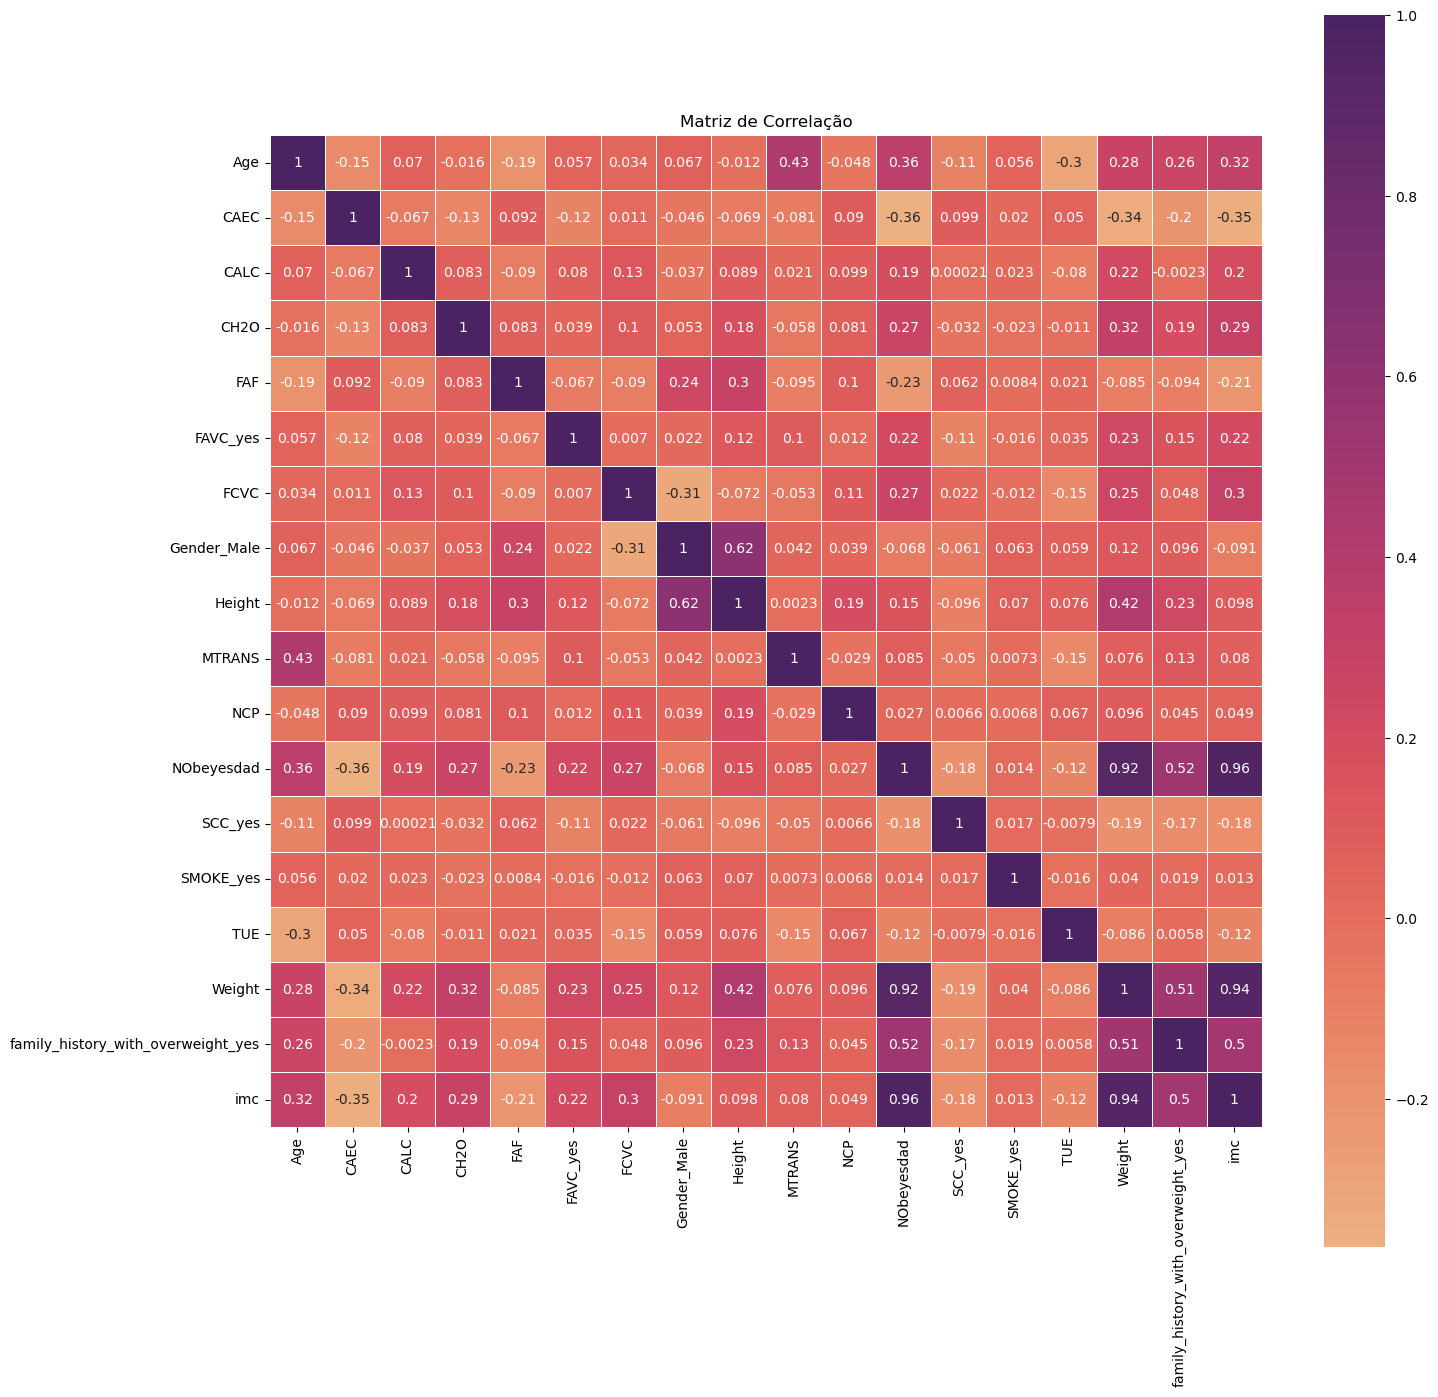

In [48]:
correlation_matrix = train.corr()

sorted_correlation = correlation_matrix['NObeyesdad'].sort_index(ascending=True)

correlated_columns = sorted_correlation.index

subset_correlation_matrix = correlation_matrix.loc[correlated_columns, correlated_columns]

plt.figure(figsize=(16, 16))
sns.heatmap(subset_correlation_matrix, annot=True, cmap='flare', square=True, linewidths= 0.5)
plt.title('Matriz de Correlação')
plt.show()


Reparamos que imc, peso e histórico familiar são os 3 maiores fatores, e que a adição do imc foi valiosa

Vamos treinar nosso modelo agora

Tirando a coluna de obesidade da parte de treino

In [49]:
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

In [52]:
model.fit(X_train, y_train)

GaussianNB()

In [53]:
model.score(X_val, y_val)

0.7745664739884393

Acurácia de 77,4% para o Naive Bayes

Bom adicionar que sem a coluna imc a acuracia foi de 65,8%